In [1]:
from influxdb import InfluxDBClient
from ruamel.yaml import YAML
import pandas as pd
import datetime as dt
from streamlit_app import Trace, JsonDec, JsonEnc
import json, os
import pandas as pd
import datetime as dt
import inspect
from dataclasses import dataclass, field, asdict
from typing import Callable

In [2]:
downloads = "C:\\Users\\holge\\Downloads"
for fn in os.listdir(downloads):
    if fn.endswith(".json"):
        print(fn)


traces (3).json
traces.json


In [3]:
traces = list()
with open(os.path.join(downloads, "traces.json")) as file:
    for trace_dict in json.load(file, cls=JsonDec)["content"]:
        trace = Trace(**trace_dict)
        traces.append(trace)
len(traces)


1

In [4]:
trace = traces[0]
trace

Trace(entity='consumption_estimate', unit='kWh/100km', line_mode='lines')

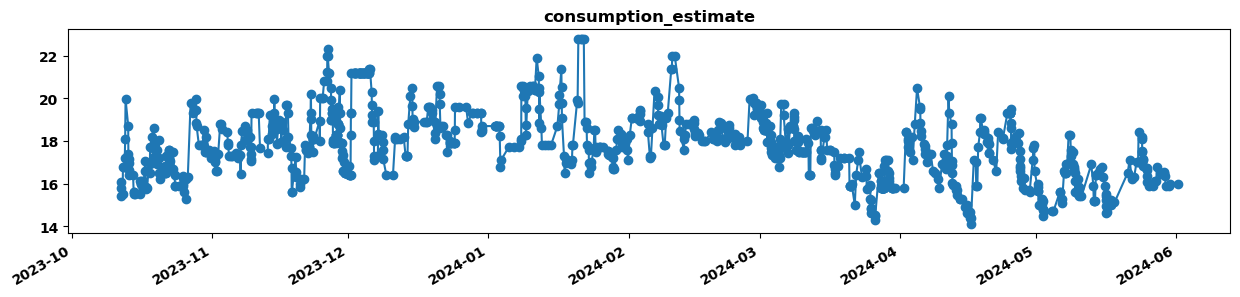

In [5]:
%matplotlib inline
trace.series.plot(figsize=(15,3), style="o-", title=trace.series.name);

In [ ]:
print("Available transformers:")
for trans_name in dir(SignalTransformers):
    if not trans_name.startswith("_"):
        print(f"- {trans_name}")
        transformer = getattr(SignalTransformers, trans_name)
        signature = inspect.signature(transformer)
        print(f"\t{signature=}")
        


In [ ]:
%matplotlib inline

In [ ]:
s2 = SignalTransformers.resample(trace.series, interval_days=0.5, fill_na=True)
ax = s2.plot(figsize=(15,3), style="o-", title=s2.name);
trace.series.plot(figsize=(15,3), style="o-", title=trace.series.name, ax=ax);
